# Training facial expression model
- Fast.ai
- kaggle.com dataset
- GPU accelerated utilising Google Colab

In [ ]:
# install latest version of fast.ai
!pip install -Uqq fastai
!pip install timm

In [3]:
from fastai.imports import *
from fastai.vision.widgets import *
from fastai.vision.all import *
from fastai.vision import *
from fastai import *
from fastai.metrics import error_rate

Google Drive must be mounted so that the train and test data can be properly extracted into the notebook.

In [4]:
# path to kaggle dataset
path = Path('/kaggle/input/emotion-detection-fer')

Extract images from Google Drive into a 'DataLoader' object. Resive the images to 224x224 pixels and normalise the RGB channels between 0-1

In [5]:
# set seed for reproducibility
np.random.seed(42)

# load data from Path obj
data = ImageDataLoaders.from_folder(path, valid="test", 
                                    item_tfms=Resize(224), 
                                    batch_tfms=Normalize.from_stats(*imagenet_stats))

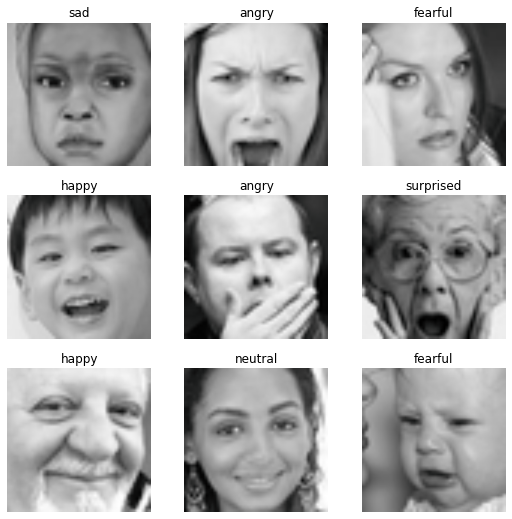

In [6]:
data.show_batch()

Initialise the image classifier model using a resnet architecture, evaluate the performance of this against other architectures later.
- The /kaggle/input directory is read-only so save files are stored in /kaggle/working

In [ ]:
timm.list_models('convnext*')

In [31]:
# create learning model with resnet34
learn = vision_learner(data, resnet34, metrics=error_rate, 
                       model_dir='/kaggle/working/models').to_fp16()

Train the random weights.

In [32]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.766014,1.408077,0.511842,02:48
1,1.255385,1.171511,0.439677,02:47
2,1.108997,1.091960,0.411257,02:48
3,1.033421,1.078501,0.403455,02:47


Not a great performance of roughly 60%. Trying unfreezing other layers and tuning the learning rate.

In [33]:
learn.save('stage-1')

Path('/kaggle/working/models/stage-1.pth')

In [34]:
learn.load('stage-1')

In [35]:
learn.unfreeze()

SuggestedLRs(valley=1.737800812406931e-05)

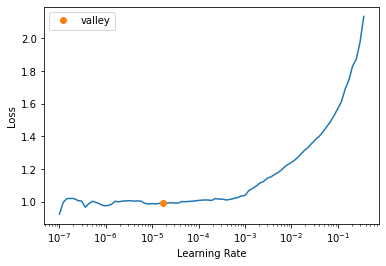

In [36]:
min_lr, max_lr = learn.lr_find()

In [ ]:
print(f'Optimal learning rate: {min_lr}')

Train the other layers using a discriminatory learning rate depending on the layer.

In [37]:
learn.fit_one_cycle(8, min_lr)

epoch,train_loss,valid_loss,error_rate,time
0,1.006291,1.007750,0.376010,03:03
1,0.968258,0.992498,0.363054,02:59
2,0.874666,1.005798,0.359850,03:01
3,0.696895,1.036631,0.350655,03:01
4,0.454628,1.143014,0.339092,02:59
5,0.274032,1.319888,0.339231,03:00
6,0.146436,1.505981,0.340763,03:00
7,0.077359,1.597431,0.329200,03:00
8,0.047469,1.629445,0.322931,03:00
9,0.018570,1.648793,0.311786,02:59


In [38]:
learn.save('stage-2')

Path('/kaggle/working/models/stage-2.pth')

In [39]:
learn.load('stage-2')

Plot a confusion matrix and the highest loss images to determine why the model is only achieving 70% accuracy.

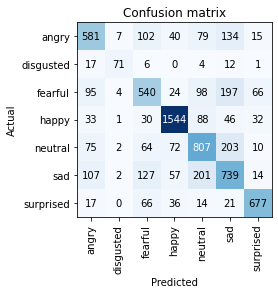

In [40]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Seems like the data is poorly labelled, using ImageClassifierCleaner to relabel and delete images that do not fit the dataset.

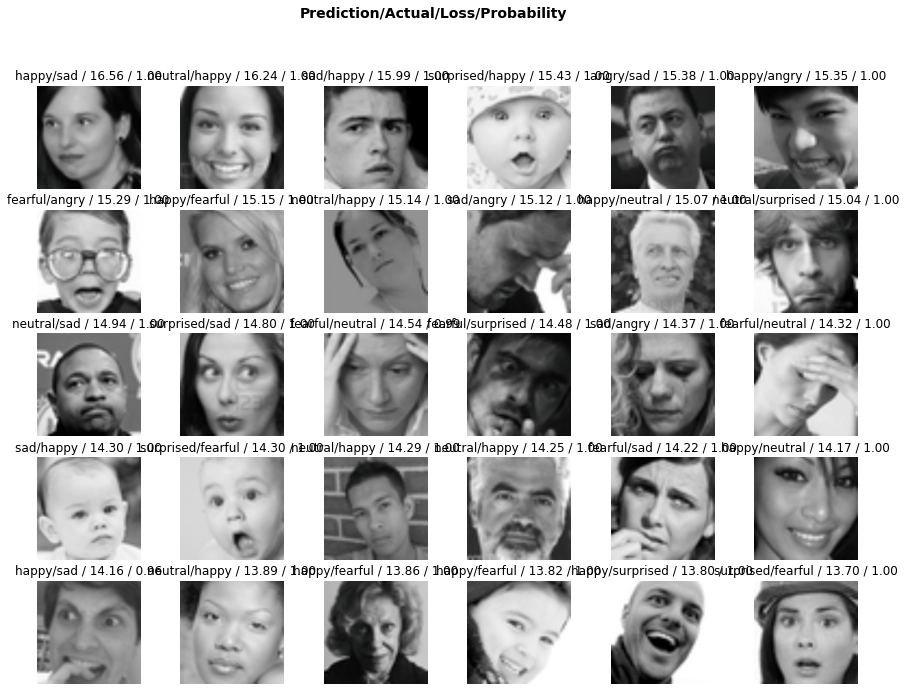

In [41]:
interp.plot_top_losses(30, figsize=(15,11))

In [41]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [18]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [20]:
files = get_image_files(path)
len(files)

35860

Model can then be retrained using cleaner data.

In [43]:
learn.export('/kaggle/working/export.pkl')